In [2]:
import os

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from brainbox.io.one import SpikeSortingLoader
from brainbox.plot import peri_event_time_histogram
from brainbox.singlecell import calculate_peths

from ibllib.atlas import AllenAtlas
from one.api import ONE

one = ONE(base_url='https://openalyx.internationalbrainlab.org', password='international', silent=True)
ba = AllenAtlas()

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

# Helper function

In [4]:
# move_times = [time for time in trials['firstMovement_times'] if time == time]


FAMILY_DIC = {'MOp': [], 'STRd': ['CP'], 'STRv': ['ACB', 'FS']}

TRIAL_PARAMS = ['stimOff_times', 'goCueTrigger_times', 'goCue_times', 'response_times', 'choice', 'stimOn_times', 'contrastLeft', 'contrastRight', 'probabilityLeft', 'feedback_times', 'feedbackType', 'rewardVolume', 'firstMovement_times', 'intervals']

def remove_nans(lis, indices):
    tes = np.array([[i,val] for i,val in enumerate(lis)])
    # print(tes)
    row_remove = np.argwhere(np.isnan(tes))
    # print("***")
    # print(row_remove)
    tes = tes[~np.isnan(tes).any(axis=1)]

    return tes, row_remove[:,0]

# move_times, removed_trials = remove_nans(trials['firstMovement_times'])
# print(len(trials['firstMovement_times']), len(move_times))
# print(removed_trials)

def get_spikedata_pid(PID):
    sl = SpikeSortingLoader(pid=PID, one=one, atlas=ba)
    spikes, clusters, channels = sl.load_spike_sorting()
    clusters = sl.merge_clusters(spikes, clusters, channels)
    return spikes, clusters, channels

def get_spikedata_eid(eid):
    PIDlist = one.eid2pid(eid)
    datalist = []
    print(PIDlist)
    for PID in PIDlist[0]:
        sl = SpikeSortingLoader(pid=PID, one=one, atlas=ba)
        spikes, clusters, channels = sl.load_spike_sorting()
        clusters = sl.merge_clusters(spikes, clusters, channels)
        datalist.append([spikes, clusters, channels])


    f, ax = plt.subplots(1, 1, figsize=(3, 3))
    
    return datalist

def select_trials(trial_data, trial_condition, condition):
    indices = [i for i, trial in enumerate(trial_data) if trial_condition[i] == condition and not math.isnan(trial)]
    result = [trial for i, trial in enumerate(trial_data) if i in indices]
    return result, indices


def get_matrices(trials, spikes, relev_neur, param = 'choice', param_condition = -1, trial_def = [3,3,0.05], trial_timing = 'firstMovement_times'):


    move_trials, trial_indices = select_trials(trials[trial_timing], trials[param], param_condition)

    #0D behavioral parameters 
    movement_choices = trials.choice[trial_indices]
    trial_results = trials.feedbackType[trial_indices]

    peth, spike_counts = calculate_peths(
        spikes.times, spikes.clusters, relev_neur,
        move_trials,
        pre_time=trial_def[0], post_time=trial_def[1], bin_size=trial_def[2], smoothing=0)

    print('peth["tscale"] contains the timebin centers relative to the event')
    print(f'\npeth["means"] is shaped: {peth["means"].shape}')
    print('This variable is NxB (neurons x timebins) and contains the mean spike rates over trials')
    print(f'\nspike_counts is shaped: {spike_counts.shape}')
    print('This variable is TxNxB (trials x neurons x timebins) and contains all spike rates per trial')

    # If you just want all the spikes over the entire 0-300 ms window you can sum like this:
    whole_window = np.sum(spike_counts, axis=2)

    print(np.linalg.norm(whole_window))
    print(f'\nwhole_window is shaped: {whole_window.shape}')
    print('This variable is TxN (trials x neurons) and contains summed spike rates per trial')

    trial_data = {}
    trial_data['movement_init_times'] = move_trials
    print(type(move_trials), len(move_trials))
    trial_data['choices'] = movement_choices
    trial_data['feedback'] = trial_results
    trial_data['trial_indices'] = trial_indices


    # f, ax = plt.subplots(1, 1, figsize=(3, 3))

    # print('SPIKE CLUS')
    # print(spikes.clusters.shape, spikes.clusters)
    # print('SPIKE TIME')
    # print(spikes.times.shape, spikes.times)


    # print('DEBUG HERE')

    # print(spikes.times.shape, spikes.clusters.shape, trials['firstMovement_times'].shape, len(relev_neur))
    # peri_event_time_histogram(spikes.times, spikes.clusters, trials['firstMovement_times'],
    #                           relev_neur,
    #                           t_before=trial_def[0], t_after=trial_def[1],
    #                           include_raster=True, error_bars='sem', ax=ax,
    #                           pethline_kwargs={'color': 'black', 'lw': 1},
    #                           errbar_kwargs={'color': 'black', 'alpha': 0.3},
    #                           raster_kwargs={'color': 'black', 'lw': 0.3},
    #                           eventline_kwargs={'lw': 0})
    # ax.set(ylabel='spikes/s', xlabel='Time (s)')
    # plt.tight_layout()
    
    

    return peth, spike_counts, trial_data

# get_matrices(trials, spikes, relev_neur)



def gen_eidlist(roi_name):
    ses = one.alyx.rest('sessions', 'list', atlas_acronym=roi_name)
    eids = [i['id'] for i in ses]
    return eids

def gen_pidlist(roi_name):
    ses = one.alyx.rest('insertions', 'list', atlas_acronym=roi_name)
    # print(f'Found {len(ses)} recordings')
    pids = [i['id'] for i in ses]
    return pids

def check_num_ses(list_of_eids):
    roi_intersection = set(list_of_eids[0]).intersection(*list_of_eids[1:])
    print('Found ' + str(len(list(roi_intersection))) +  'recording sessions')
    return len(list(roi_intersection)), roi_intersection


#family_dictionary = ['MOp1': ']

def is_child_of(child, parent, family_dictionary=FAMILY_DIC):
    if parent in child:
        return True

    # print(family_dictionary.keys())
    if parent not in family_dictionary.keys():
        return False
    elif child in family_dictionary[parent]:
        return True
    else:
        return False

def get_data_per_recording(eid, corr_regions, trial_def = [3,3,0.05], trial_timing = 'firstMovement_times'):
    datalist = get_spikedata_eid(eid)
    trials = one.load_object(eid, 'trials')

    region_2_relevneur = {}
    region_2_data = {}

    # def get_matrices(trials, spikes, relev_neur, param = 'choice', param_condition = -1):
    count = 0
    for region in corr_regions:
        relev_neur_list = []

        probe = 0
        relev_neur_0 = [i for i, acronym in enumerate(datalist[probe][1]['acronym']) if is_child_of(acronym, region)]
        if len(relev_neur_0) > 0: #will be performed if datalist has one probe OR has two probes
                relev_neur_list.append(relev_neur_0)
        if len(datalist) > 1: # if two probes
            probe = 1
            relev_neur_1 = [i for i, acronym in enumerate(datalist[probe][1]['acronym']) if is_child_of(acronym, region)]
            if len(relev_neur_1) > 0:
                relev_neur_list.append(relev_neur_1)
        dic = {}
        for condition in [-1,1]:
            mini_dic = {}
            probe = 0
            peth, spike_counts, trial_data = get_matrices(trials, datalist[probe][0], relev_neur_list[probe], param = 'choice', param_condition=condition, trial_def = trial_def, trial_timing=trial_timing)
            if len(relev_neur_list) > 1:
                probe = 1
                peth1, spike_counts1, trial_data1 = get_matrices(trials, datalist[probe][0], relev_neur_list[probe], param = 'choice', param_condition=condition, trial_def = trial_def, trial_timing=trial_timing)

            mini_dic['peth'] = peth #not updating this cuz we never use it  
            #TxNxB (trials x neurons x timebins)
            if len(relev_neur_list) > 1:
                conglom_spikes = np.hstack([spike_counts, spike_counts1])
                print('spike_counts CONGLOM.shape: ', conglom_spikes.shape)
                mini_dic['spike_counts'] = conglom_spikes
                # conglom_trial_data = {}
                # for key in trial_data:
                #     conglom_trial = np.hstack([trial_data[key], trial_data1[key]])
                #     print('trial_data CONGLOM.shape: ', conglom_trial.shape)
                #     conglom_trial_data[key] = conglom_trial
                mini_dic['trial_data'] = trial_data
            else:
                mini_dic['spike_counts'] = spike_counts
                mini_dic['trial_data'] = trial_data
          
            dic[condition] = mini_dic
        region_2_data[region] = dic

    return region_2_data


**Projectome data loading**

In [ ]:
projectome = pd.read_excel('proj_strengths_sup3.xlsx', sheet_name='W_ipsi', index_col = 0)
print("Source is rows, Target is columns")

Source is rows, Target is columns


/usr/local/lib/python3.9/dist-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [ ]:
projec_roi = projectome.columns

In [ ]:
source = 'VM'
target = 'VAL'
projectome.loc[source, target]

0.0

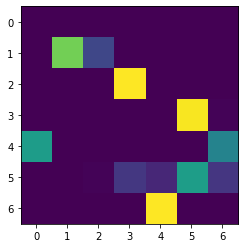

In [ ]:
strengths = np.zeros([7,7])
for i,source in enumerate(rois_opt):
    for j, target in enumerate(rois_opt):
        # print(round(projectome.loc[source, target], 2))
        strengths[i,j] = projectome.loc[source, target]
    if np.sum(strengths[i,:]) > 0:
        strengths[i,:] /= np.sum(strengths[i,:])
plt.imshow(strengths)
strength_df = pd.DataFrame(strengths, columns = rois_opt, index = rois_opt)

In [ ]:
strength_df

,CM,DG,CA1,LP,MRN,PTLp,APN
CM,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DG,0.000000,0.786168,0.213832,0.000000,0.000000,0.000000,0.000000
CA1,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
LP,0.000000,0.000000,0.000000,0.000000,0.000000,0.988383,0.011617
MRN,0.554347,0.000000,0.000000,0.000000,0.000000,0.000000,0.445653
PTLp,0.000070,0.000000,0.010600,0.162417,0.111364,0.557438,0.158112
APN,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000


In [ ]:
strengths[,:]

array([0., 0., 0., 1., 0., 0., 0.])

1.5) Other dataset gen

In [ ]:
example_regions = ['VM']#, 'VAL']#, 'MOp']

In [ ]:
regions = [region[0] for region in pd.read_csv('chosen_brainregions.csv', header = None).values]
print(regions)

['LP', 'CP', 'MOp', 'MOs', 'VM', 'VAL', 'CA1', 'SCm', 'VPM', 'VISp', 'MRN', 'DG', 'CA1', 'PTLp']


In [ ]:
ignorelist = ['1b20f589-6177-4e5c-9090-9a609a16944b', 'b01df337-2d31-4bcc-a1fe-7112afd50c50']
for region in regions:
  if region in regions[:4]:
    continue

  print(region)
  eids = gen_eidlist(region)
  pids = gen_pidlist(region)
  for i,eid in enumerate(eids):
    if eid in ignorelist:
      continue
    if i >= 10:
      print("breakin")
      break
    print(eid)
    trial = one.load_object(eid, "trials")
                  

In [ ]:
starter = 'MOp'
ses = one.alyx.rest('insertions', 'list', atlas_acronym=starter)
print(f'Found {len(ses)} recordings')
pids = [i['id'] for i in ses]

for i, PID in enumerate(pids):

    EID = one.pid2eid(PID)
    trials = one.load_object(EID[0], "trials")
    sl = SpikeSortingLoader(pid=PID, one=one, atlas=ba)
    spikes, clusters, channels = sl.load_spike_sorting()
    clusters = sl.merge_clusters(spikes, clusters, channels)
    print(clusters['acronym'])

In [ ]:
def gen_fatdata(regions, behav_param, trial_def=[2,2,0.25]):
  roi_info = {}
  for roi in regions:
    info = {}
    ses = one.alyx.rest('insertions', 'list', atlas_acronym=roi)
    print(f'Found {len(ses)} recordings')
    pids = [i['id'] for i in ses]
    eids = [i['session'] for i in ses]
    info['pids'] = pids
    info['eids'] = eids
    for i,PID in enumerate(pids):
      if i == 10:
        break
      sl = SpikeSortingLoader(pid=PID, one=one, atlas=ba)
      EID = one.pid2eid(PID)[0]
      print(EID)
      if EID == 'b01df337-2d31-4bcc-a1fe-7112afd50c50':
        continue
      trials = one.load_object(EID, "trials")
      spikes, clusters, channels = sl.load_spike_sorting()
      clusters = sl.merge_clusters(spikes, clusters, channels)
      neur_relev = []
      if clusters is not None:
        neur_relev = [i for i, acronym in enumerate(clusters['acronym']) if roi in acronym]
        print(f'Found {len(neur_relev)} ' + roi + ' neurons')
        dic = {}
        for condition in [-1,1]:
          mini_dic = {}
          peth, spike_counts, trial_data = get_matrices(trials, spikes, neur_relev, param = behav_param, param_condition=condition, trial_def = trial_def)
          mini_dic['peth'] = peth
          mini_dic['spike_counts'] = spike_counts
          mini_dic['trial_data'] = trial_data
          dic[condition] = mini_dic
      info[PID] = dic
    roi_info[roi] = info
  return roi_info

In [ ]:
roi_info = gen_fatdata(example_regions, 'choice')

2) **For finding the number (and regions) of simultaneous recordings for each EID. Not necessary to run if already determined which EID(s) to use**

In [ ]:
#loads in csv of brain regions from projection matrix
regions = pd.read_csv('proj_brainregions.csv').columns
roi_comp = []
for i,region in enumerate(regions):
    if region == 'fiber tracts':
        continue
    roi_comp.append(region.split('.')[0])

In [ ]:
len(regions)

591

In [ ]:
# sets up eid_dic which contains roi -> list of eid
eid_dic = {}
all_eids = set()
for roi in roi_comp:
    print(roi + ' EID list')
    eids = gen_eidlist(roi)
    print(len(eids), eids)
    eid_dic[roi] = eids
    all_eids.update(eids)

all_eids = list(all_eids)
roi_records = []

roi_dic = {}
for i,eid in enumerate(all_eids):
    roilist = [roi for roi in eid_dic.keys() if eid in eid_dic[roi]]
    roi_dic[eid] = roilist
    roi_records.append(roilist)


<BarContainer object of 295 artists>

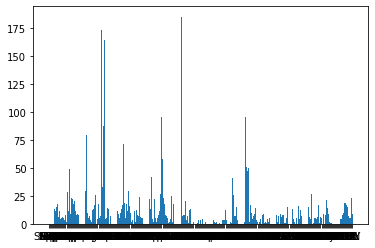

In [ ]:
distinct_rois, roi_eid_counts = [r for r in eid_dic], [len(v) for v in eid_dic.values()]
plt.bar(distinct_rois, roi_eid_counts)

In [ ]:
sorted_idx = np.argsort(roi_eid_counts)
top_rois = [distinct_rois[i] for i in sorted_idx[-20:]]
top_rois.reverse()

In [ ]:
len_left = 0
roilist = [top_rois[0]]
eidset = set(eid_dic[top_rois[0]])

reduc_list = top_rois[1:]
for i in range(len(top_rois)-1):
  if i == len(top_rois):
    break
  
  sublist = top_rois[i+1:]
  print(sublist)
  max_overlap = [0,'']
  for roi in reduc_list:
    overlapsize = len(eidset & set(eid_dic[roi]))
    if overlapsize > max_overlap[0]:
        max_overlap[0] = overlapsize
        max_overlap[1] = roi
  roilist.append(max_overlap[1])
  reduc_list.remove(max_overlap[1])

  
roilist

In [ ]:
sorted_idx = np.argsort(roi_eid_counts)
top_rois = [distinct_rois[i] for i in sorted_idx[-50:]]
top_rois.reverse()


eidset = set(eid_dic[top_rois[0]])
best_arrangement = []


for j in range(10000):
  if j == 0:
    continue
  top_rois.shuffle
  for i,roi in enumerate(top_rois):
    if i == 0:
      continue
    eidset = eidset & set(eid_dic[top_rois[i]])
    print(len(eidset))

In [ ]:
eidset = set(eid_dic[roilist[0]])
  
for i,roi in enumerate(roilist):
  if i == 0:
    continue
  eidset = eidset & set(eid_dic[roilist[i]])

  print(len(eidset))
  if i == 6:
    print(eidset)

91
78
59
18
10
9
{'4b7fbad4-f6de-43b4-9b15-c7c7ef44db4b', 'e2b845a1-e313-4a08-bc61-a5f662ed295e', 'f312aaec-3b6f-44b3-86b4-3a0c119c0438', '6c6b0d06-6039-4525-a74b-58cfaa1d3a60', '3e6a97d3-3991-49e2-b346-6948cb4580fb', 'ecb5520d-1358-434c-95ec-93687ecd1396', '2bdf206a-820f-402f-920a-9e86cd5388a4', 'b22f694e-4a34-4142-ab9d-2556c3487086', '9b528ad0-4599-4a55-9148-96cc1d93fb24'}
0
0
0
0
0
0
0
0
0
0
0
0
0


In [ ]:
roilist[:7]

['CM', 'DG', 'CA1', 'LP', 'MRN', 'PTLp', 'APN']

In [ ]:
rois_opt = roilist[:7]

eid_list = ['4b7fbad4-f6de-43b4-9b15-c7c7ef44db4b', 'e2b845a1-e313-4a08-bc61-a5f662ed295e', 'f312aaec-3b6f-44b3-86b4-3a0c119c0438', '6c6b0d06-6039-4525-a74b-58cfaa1d3a60', '3e6a97d3-3991-49e2-b346-6948cb4580fb', 'ecb5520d-1358-434c-95ec-93687ecd1396', '2bdf206a-820f-402f-920a-9e86cd5388a4', 'b22f694e-4a34-4142-ab9d-2556c3487086', '9b528ad0-4599-4a55-9148-96cc1d93fb24']
for eid in eid_list:
    eidset = set(roi_dic[eid]) & set(rois_opt)
    print(len(eidset) == len(rois_opt))

True
True
True
True
True
True
True
True
True


In [ ]:
rois_opt = ['CM', 'DG', 'CA1', 'LP', 'MRN', 'PTLp', 'APN']

In [ ]:
pid = one.eid2pid('4b7fbad4-f6de-43b4-9b15-c7c7ef44db4b')


sl = SpikeSortingLoader(pid=pid, one=one, atlas='CM')
spikes, clusters, channels = sl.load_spike_sorting()
clusters = sl.merge_clusters(spikes, clusters, channels)

print(clusters['acronym'])

HTTPError: ignored

THE DATASET GENERATION

In [ ]:
eid_list = ['4b7fbad4-f6de-43b4-9b15-c7c7ef44db4b', 'e2b845a1-e313-4a08-bc61-a5f662ed295e', 'f312aaec-3b6f-44b3-86b4-3a0c119c0438', '6c6b0d06-6039-4525-a74b-58cfaa1d3a60', '3e6a97d3-3991-49e2-b346-6948cb4580fb', 'ecb5520d-1358-434c-95ec-93687ecd1396', '2bdf206a-820f-402f-920a-9e86cd5388a4', 'b22f694e-4a34-4142-ab9d-2556c3487086', '9b528ad0-4599-4a55-9148-96cc1d93fb24']
eid_list = ['4b7fbad4-f6de-43b4-9b15-c7c7ef44db4b']
simul_regions = ['CM', 'DG', 'CA1', 'LP', 'MRN', 'PTLp', 'APN']
whole_dataset = {}
for eid in eid_list:
    
    region_2_dat = get_data_per_recording(eid, simul_regions)
    whole_dataset[eid] = region_2_dat

# Some manual stuff


In [ ]:
num, motor_intersec = check_num_ses([gen_eidlist('STRv'), gen_eidlist('STRd'), gen_eidlist('MOp'), gen_eidlist('MOs')])
motor_intersec = list(motor_intersec)
m_regions = ['STRv', 'STRd', 'MOp', 'MOs']
print(motor_intersec)

Found 3recording sessions
['81a78eac-9d36-4f90-a73a-7eb3ad7f770b', 'ee8b36de-779f-4dea-901f-e0141c95722b', '88d24c31-52e4-49cc-9f32-6adbeb9eba87']


# @Akash - motor related regions dataset generation

(['1ef94d02-d51a-491f-a313-1bb5238d6b8b', 'b375a0ee-4c5a-4a53-9cea-d753f206e5c5'], ['probe01', 'probe00'])
peth["tscale"] contains the timebin centers relative to the event

peth["means"] is shaped: (116, 120)
This variable is NxB (neurons x timebins) and contains the mean spike rates over trials

spike_counts is shaped: (284, 116, 120)
This variable is TxNxB (trials x neurons x timebins) and contains all spike rates per trial
3315.6106526551034

whole_window is shaped: (284, 116)
This variable is TxN (trials x neurons) and contains summed spike rates per trial
<class 'list'> 284
peth["tscale"] contains the timebin centers relative to the event

peth["means"] is shaped: (116, 120)
This variable is NxB (neurons x timebins) and contains the mean spike rates over trials

spike_counts is shaped: (267, 116, 120)
This variable is TxNxB (trials x neurons x timebins) and contains all spike rates per trial
3513.080699329294

whole_window is shaped: (267, 116)
This variable is TxN (trials x neur

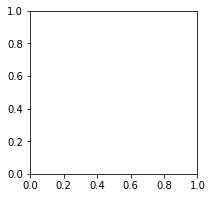

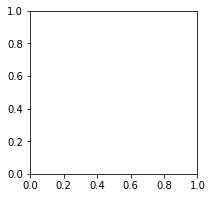

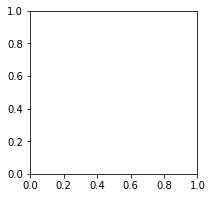

In [ ]:
eid_list = ['ee8b36de-779f-4dea-901f-e0141c95722b', '81a78eac-9d36-4f90-a73a-7eb3ad7f770b', '88d24c31-52e4-49cc-9f32-6adbeb9eba87']
m_regions = ['STRv', 'STRd', 'MOp', 'MOs']
m_whole_dataset = {}
for eid in eid_list:
    region_2_dat = get_data_per_recording(eid, m_regions)
    m_whole_dataset[eid] = region_2_dat

In [ ]:
def verify_regions_pereid(eid, roisois):
    print('eid: ', eid)
    pid = one.eid2pid(eid)
    dis_eid_good = False
    for i,pid in enumerate(pid[0]):
        sl = SpikeSortingLoader(pid=pid, one=one, atlas=ba)
        spikes, clusters, channels = sl.load_spike_sorting()
        clusters = sl.merge_clusters(spikes, clusters, channels)
        rois = clusters['acronym']
        print('pid numba: ', i)
        # print(rois)
        
        for cluster in spike.clusters:
          print(cluster)
        
        for region in roisois:
            relev_neur = [i for i, acronym in enumerate(clusters['acronym']) if region in acronym]
            print(region, relev_neur)
        

    

# for eid in motor_intersec:
#     verify_regions_pereid(eid, m_regions)

verify_regions_pereid(motor_intersec[0], m_regions)

eid:  ee8b36de-779f-4dea-901f-e0141c95722b
pid numba:  0
clusters:  [462  28 428 ...  22 376 286]
STRv []
STRd []
MOp []
MOs []
pid numba:  1
clusters:  [ 39 108 160 ... 247  89 142]
STRv []
STRd []
MOp [87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 283, 284, 285, 286]
MOs [69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 219]


In [ ]:
len(clusters['channels'])

288

In [ ]:
clusters['acronym']

array(['V3', 'V3', 'V3', 'V3', 'V3', 'V3', 'V3', 'V3', 'V3', 'V3', 'V3',
       'V3', 'V3', 'V3', 'V3', 'V3', 'V3', 'V3', 'V3', 'V3', 'V3', 'V3',
       'V3', 'V3', 'V3', 'V3', 'V3', 'V3', 'V3', 'V3', 'V3', 'V3', 'V3',
       'V3', 'V3', 'V3', 'V3', 'fi', 'fi', 'fi', 'LSc', 'LSc', 'LSc',
       'LSc', 'LSc', 'LSc', 'LSc', 'LSc', 'LSc', 'LSc', 'LSc', 'LSc',
       'LSc', 'LSc', 'LSc', 'LSc', 'LSc', 'LSc', 'LSc', 'LSc', 'LSc',
       'VL', 'VL', 'VL', 'VL', 'VL', 'VL', 'VL', 'VL', 'MOs6a', 'MOs6a',
       'MOs6a', 'MOs6a', 'MOs6a', 'MOs6a', 'MOs6a', 'MOs6a', 'MOs6a',
       'MOs6a', 'MOs6a', 'MOs6a', 'MOs6a', 'MOs6a', 'MOs6a', 'MOs6a',
       'MOs6a', 'MOs6a', 'MOp5', 'MOp5', 'MOp5', 'MOp5', 'MOp5', 'MOp5',
       'MOp5', 'MOp5', 'MOp5', 'MOp5', 'MOp5', 'MOp5', 'MOp5', 'MOp5',
       'MOp5', 'MOp5', 'MOp5', 'MOp5', 'MOp5', 'MOp5', 'MOp5', 'MOp5',
       'MOp5', 'MOp5', 'MOp5', 'MOp5', 'MOp5', 'MOp5', 'MOp2/3', 'MOp2/3',
       'MOp2/3', 'MOp2/3', 'MOp2/3', 'MOp2/3', 'MOp2/3', 'MOp2/3',
 

In [ ]:
max(spikes.clusters)

287

In [ ]:
motor_dataset = {}

for eid in motor_intersec:
    region_2_dat = get_data_per_recording(eid, m_regions)
    motor_dataset[eid] = region_2_dat

Found 1recording sessions


1

In [ ]:
regions = ['VAL', 'VM', 'VPM', 'LP', 'VPL', 'MOs', 'MOp', 'VISp', 'CP', 'DN']
regions = ['MOs', 'CP', '']
bigset = set(gen_eds(regions[0]))

print('big', bigset)
for region in regions:
    bigset = bigset & set(gen_eds(region))

print(f'Found {len(list(bigset))} recording sessions')
print(list(bigset))

big {'ae8787b1-4229-4d56-b0c2-566b61a25b77', '9468fa93-21ae-4984-955c-e8402e280c83', '2e6e179c-fccc-4e8f-9448-ce5b6858a183', 'f8041c1e-5ef4-4ae6-afec-ed82d7a74dc1', 'ee8b36de-779f-4dea-901f-e0141c95722b', '65f5c9b4-4440-48b9-b914-c593a5184a18', '88d24c31-52e4-49cc-9f32-6adbeb9eba87', '36280321-555b-446d-9b7d-c2e17991e090', 'ff4187b5-4176-4e39-8894-53a24b7cf36b', '9e9c6fc0-4769-4d83-9ea4-b59a1230510e', '0f77ca5d-73c2-45bd-aa4c-4c5ed275dbde', '2c44a360-5a56-4971-8009-f469fb59de98', '1191f865-b10a-45c8-9c48-24a980fd9402', 'cf43dbb1-6992-40ec-a5f9-e8e838d0f643', 'dd4da095-4a99-4bf3-9727-f735077dba66', 'fb70ebf7-8175-42b0-9b7a-7c6e8612226e', 'ebc9392c-1ecb-4b4b-a545-4e3d70d23611', '196a2adf-ff83-49b2-823a-33f990049c2e', '8207abc6-6b23-4762-92b4-82e05bed5143', '81a78eac-9d36-4f90-a73a-7eb3ad7f770b', '1e45d992-c356-40e1-9be1-a506d944896f', 'ac7d3064-7f09-48a3-88d2-e86a4eb86461', 'aad23144-0e52-4eac-80c5-c4ee2decb198', '19b44992-d527-4a12-8bda-aa11379cb08c', '4ddb8a95-788b-48d0-8a0a-66c7c796da

In [ ]:
eid_cumulative = []
from collections import Counter
for roi in top_rois:
    eid_cumulative += eid_dic[roi]
eidcounts = Counter(eid_cumulative)
max(eidcounts.values())

16

In [ ]:
sorted_eid = np.argsort(list(eidcounts.values()))
eid_relev = list(eidcounts.keys())
top50_eids = [eid_relev[i] for i in sorted_eid[-50:]]
top50_eids.reverse()
eidcounts[top50_eids[0]]

16

In [ ]:
roi_dic[top50_eids[0]]

['VISpm',
 'RSPagl',
 'RSPd',
 'RSPv',
 'PTLp',
 'CA1',
 'CA2',
 'CA3',
 'DG',
 'VPL',
 'VPM',
 'LGd',
 'ZI',
 'SCs',
 'MRN',
 'SCm',
 'RN']

In [ ]:
roiset = set(roi_dic[top50_eids[0]])
for i,roi in enumerate(top50_eids):
    if i == 0:
      continue
    roiset = roiset & set(roi_dic[top50_eids[i]])
    print(len(roiset))

The EID with the most simultaneous recordings is: 2c44a360-5a56-4971-8009-f469fb59de98 with 19
Rois:  ['MOp', 'MOs', 'ACAd', 'ACAv', 'PL', 'ILA', 'TT', 'DP', 'CA3', 'DG', 'ACB', 'OT', 'LSr', 'SI', 'AMd', 'IAD', 'MD', 'PVT', 'CM']


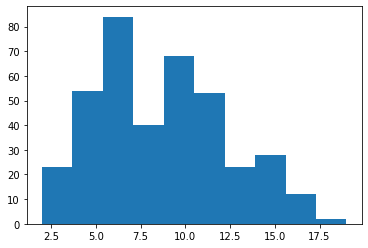

In [ ]:
record_lens = [len(record) for record in roi_records]
highscore_ind = np.argmax(record_lens)

plt.hist(record_lens)

# highscore_ind is the index corresponding to an eid
# 
eid_most = all_eids[highscore_ind]
corr_regions = roi_records[highscore_ind]
print('The EID with the most simultaneous recordings is: ' + eid_most + ' with ' + str(len(corr_regions)))
print('Rois: ', corr_regions)

3) Dataset generation below

In [ ]:

eid_most = '2c44a360-5a56-4971-8009-f469fb59de98'
corr_regions = ['MOp', 'MOs', 'ACAd', 'ACAv', 'PL', 'ILA', 'TT', 'DP', 'CA3', 'DG', 'ACB', 'OT', 'LSr', 'SI', 'AMd', 'IAD', 'MD', 'PVT', 'CM']

#this code is written for an eid with two pids (two probes)



In [ ]:
diff = 0
for i,trial in enumerate(trials['goCueTrigger_times']):
    if i == len(trials['goCueTrigger_times'])-1:
        break
    diff += trials['goCueTrigger_times'][i+1] - trials['goCueTrigger_times'][i]
print(diff/i)

4.601481504547704


In [ ]:
#summarize dimensions
#peth means is neurons by time (averaged over trials)
#spike_counts is trials by neurons by time
#trial_data contains behavioral parameters (choice, feedback, movement_initiation_time, etc)

for roi in region_2_data:
    print('ROI: ', roi)
    for condition in [-1,1]:
        print('Choice: ', condition)
        print(region_2_data[roi][condition]['peth']['means'].shape)
        print(region_2_data[roi][condition]['spike_counts'].shape)
        print(region_2_data[roi][condition]['trial_data']['choices'].shape)

In [ ]:
squash = 'mean'
region_2_data = whole_dataset['e2b845a1-e313-4a08-bc61-a5f662ed295e']
rois = region_2_data.keys()
for ex_roi in rois:
    num_trials = region_2_data[ex_roi][-1]['trial_data']['choices'].shape[0] + region_2_data[ex_roi][1]['trial_data']['choices'].shape[0]
    training_size = 480
    T = region_2_data[ex_roi][1]['spike_counts'].shape[-1]
    whole_data = []
    whole_outputs = []

    for condition in [-1,1]:
        spike_counts = region_2_data[ex_roi][condition]['spike_counts']
        if squash == 'mean':
            print("yo madda")
            # print(spike_counts.shape)
            dat = np.mean(spike_counts, axis=1) #averaging over neurons
            # print(dat.shape)
        elif squash == 'vec':
            dat = spike_counts.reshape(spike_counts.shape[0],-1)

        whole_data.append(dat)
        whole_outputs.append(region_2_data[ex_roi][condition]['trial_data']['choices'])
    whole_data = np.vstack(whole_data)
    whole_outputs = np.hstack(whole_outputs)
    print(whole_data.shape, whole_outputs.shape)

yo madda
yo madda
(600, 120) (600,)
yo madda
yo madda
(600, 120) (600,)
yo madda
yo madda
(600, 120) (600,)
yo madda
yo madda
(600, 120) (600,)
yo madda
yo madda
(600, 120) (600,)
yo madda
yo madda
(600, 120) (600,)
yo madda
yo madda
(600, 120) (600,)


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [ ]:
count = 0
for eid in whole_dataset.keys():
    for roi in whole_dataset[eid].keys():
        for condition in [-1,1]:
            count += 1
            a = whole_dataset[eid][ex_roi][condition]['spike_counts']
            print(whole_dataset[eid][ex_roi][condition]['spike_counts'].shape)
print(count)

# Making predictions

In [ ]:
#first pass classification task
from sklearn.model_selection import train_test_split
from sklearn import metrics
def check_accuracy_peregion(big_data, model, squash = 'mean', across_recordings = True):

    tall_mat = []
    tall_outputs = []
    print('KEYS: ', big_data.keys())

    roi_2_datas = {}
    roi_2_outputs = {}
    for eid in big_data.keys():
        print('**EID: ', eid)
        region_2_data = big_data[eid]
        rois = region_2_data.keys()
        for ex_roi in rois:
            num_trials = region_2_data[ex_roi][-1]['trial_data']['choices'].shape[0] + region_2_data[ex_roi][1]['trial_data']['choices'].shape[0]
            print(num_trials)
            training_size = 480
            T = region_2_data[ex_roi][1]['spike_counts'].shape[-1]
            whole_data = []
            whole_outputs = []
            dat = None
            for condition in [-1,1]:
                spike_counts = region_2_data[ex_roi][condition]['spike_counts']
                if spike_counts.shape[1] == 0:
                    continue
                if squash == 'mean':
                    # print(spike_counts.shape)
                    dat = np.mean(spike_counts, axis=1) #averaging over neurons
                    # print(dat.shape)
                elif squash == 'vec':
                    dat = spike_counts.reshape(spike_counts.shape[0],-1)

                whole_data.append(dat)
                whole_outputs.append(region_2_data[ex_roi][condition]['trial_data']['choices'])
            if len(whole_data) == 0:
                continue
            whole_data = np.vstack(whole_data)
            whole_outputs = np.hstack(whole_outputs)

            if not across_recordings:
                X_train, X_test, y_train, y_test = train_test_split(whole_data, whole_outputs, test_size=0.2)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                # Model Accuracy: how often is the classifier correct?
                print(ex_roi + " accuracy:",metrics.accuracy_score(y_test, y_pred))

            if ex_roi not in roi_2_datas.keys():
                roi_2_datas[ex_roi] = []
                roi_2_outputs[ex_roi] = []
            roi_2_datas[ex_roi].append(whole_data)
            roi_2_outputs[ex_roi].append(whole_outputs)
            
    if across_recordings:
        for roi in rois:
            massive_dat = np.vstack(roi_2_datas[roi])
            massive_out = np.hstack(roi_2_outputs[roi])
            print("massive_dat shape: ", massive_dat.shape)
            print("massive_out.shape: ", massive_out.shape)
            X_train, X_test, y_train, y_test = train_test_split(massive_dat, massive_out, test_size=0.2)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            # Model Accuracy: how often is the classifier correct?
            print(roi + " accuracy:",metrics.accuracy_score(y_test, y_pred))

from sklearn import svm
clf = svm.SVC(kernel='rbf')
check_accuracy_peregion(m_whole_dataset, clf, squash = 'mean', across_recordings = True)

check_accuracy_peregion(m_whole_dataset, clf, squash = 'vec', across_recordings = False)

# @Akash, making variants of the dataset w diff trial_definitions

Playing around with trial definitions

In [ ]:
eid_list = ['ee8b36de-779f-4dea-901f-e0141c95722b', '81a78eac-9d36-4f90-a73a-7eb3ad7f770b', '88d24c31-52e4-49cc-9f32-6adbeb9eba87']
m_whole_dataset_alt = {}
for eid in eid_list:
    region_2_dat = get_data_per_recording(eid, m_regions, trial_def = [2,2,0.025]) #[time before movement init, time after, timebin]
    m_whole_dataset_alt[eid] = region_2_dat

In [ ]:
check_accuracy_peregion(m_whole_dataset_alt, clf, squash = 'mean', across_recordings = True)

check_accuracy_peregion(m_whole_dataset_alt, clf, squash = 'vec', across_recordings = False)

KEYS:  dict_keys(['ee8b36de-779f-4dea-901f-e0141c95722b', '81a78eac-9d36-4f90-a73a-7eb3ad7f770b', '88d24c31-52e4-49cc-9f32-6adbeb9eba87'])
**EID:  ee8b36de-779f-4dea-901f-e0141c95722b
551
551
551
551
**EID:  81a78eac-9d36-4f90-a73a-7eb3ad7f770b
1103
1103
1103
1103
**EID:  88d24c31-52e4-49cc-9f32-6adbeb9eba87
545
545
545
545
massive_dat shape:  (2199, 160)
massive_out.shape:  (2199,)
STRv accuracy: 0.6136363636363636
massive_dat shape:  (2199, 160)
massive_out.shape:  (2199,)
STRd accuracy: 0.6568181818181819
massive_dat shape:  (2199, 160)
massive_out.shape:  (2199,)
MOp accuracy: 0.6613636363636364
massive_dat shape:  (2199, 160)
massive_out.shape:  (2199,)
MOs accuracy: 0.6136363636363636
KEYS:  dict_keys(['ee8b36de-779f-4dea-901f-e0141c95722b', '81a78eac-9d36-4f90-a73a-7eb3ad7f770b', '88d24c31-52e4-49cc-9f32-6adbeb9eba87'])
**EID:  ee8b36de-779f-4dea-901f-e0141c95722b
551
STRv accuracy: 0.7837837837837838
551
STRd accuracy: 0.9099099099099099
551
MOp accuracy: 0.8738738738738738
551

In [ ]:
eid_list = ['ee8b36de-779f-4dea-901f-e0141c95722b', '81a78eac-9d36-4f90-a73a-7eb3ad7f770b', '88d24c31-52e4-49cc-9f32-6adbeb9eba87']
m_whole_dataset_stim_aligned = {}
for eid in eid_list:
    region_2_dat = get_data_per_recording(eid, m_regions, trial_def = [2,4,0.05], trial_timing = 'stimOn_times') #this we align trials on the stimulus time (not movement)
    m_whole_dataset_stim_aligned[eid] = region_2_dat

In [ ]:
check_accuracy_peregion(m_whole_dataset_stim_aligned, clf, squash = 'mean', across_recordings = True)

check_accuracy_peregion(m_whole_dataset_stim_aligned, clf, squash = 'vec', across_recordings = False)

KEYS:  dict_keys(['ee8b36de-779f-4dea-901f-e0141c95722b', '81a78eac-9d36-4f90-a73a-7eb3ad7f770b', '88d24c31-52e4-49cc-9f32-6adbeb9eba87'])
**EID:  ee8b36de-779f-4dea-901f-e0141c95722b
551
551
551
551
**EID:  81a78eac-9d36-4f90-a73a-7eb3ad7f770b
1103
1103
1103
1103
**EID:  88d24c31-52e4-49cc-9f32-6adbeb9eba87
546
546
546
546
massive_dat shape:  (2200, 120)
massive_out.shape:  (2200,)
STRv accuracy: 0.5977272727272728
massive_dat shape:  (2200, 120)
massive_out.shape:  (2200,)
STRd accuracy: 0.6840909090909091
massive_dat shape:  (2200, 120)
massive_out.shape:  (2200,)
MOp accuracy: 0.7068181818181818
massive_dat shape:  (2200, 120)
massive_out.shape:  (2200,)
MOs accuracy: 0.7068181818181818
KEYS:  dict_keys(['ee8b36de-779f-4dea-901f-e0141c95722b', '81a78eac-9d36-4f90-a73a-7eb3ad7f770b', '88d24c31-52e4-49cc-9f32-6adbeb9eba87'])
**EID:  ee8b36de-779f-4dea-901f-e0141c95722b
551
STRv accuracy: 0.7477477477477478
551
STRd accuracy: 0.918918918918919
551
MOp accuracy: 0.8378378378378378
551


In [ ]:


check_accuracy_peregion(whole_dataset, clf, squash = 'mean')
print('\nWith vectorize')
check_accuracy_peregion(whole_dataset, clf, quash = 'vec')

In [ ]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
check_accuracy_peregion(clf, squash = 'mean')
print('\nWith vectorize')
check_accuracy_peregion(clf, squash = 'vec')

ValueError: ignored

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
check_accuracy_peregion(clf)

MOp accuracy: 0.5833333333333334
MOs accuracy: 0.6416666666666667
ACAd accuracy: 0.6833333333333333
ACAv accuracy: 0.6166666666666667
PL accuracy: 0.7166666666666667
ILA accuracy: 0.6583333333333333
TT accuracy: 0.5833333333333334
DP accuracy: 0.5666666666666667
CA3 accuracy: 0.6416666666666667
DG accuracy: 0.5583333333333333
ACB accuracy: 0.5833333333333334
OT accuracy: 0.5583333333333333
LSr accuracy: 0.5833333333333334
SI accuracy: 0.6
AMd accuracy: 0.5666666666666667
IAD accuracy: 0.6416666666666667
MD accuracy: 0.6
PVT accuracy: 0.6166666666666667
CM accuracy: 0.5833333333333334


In [ ]:
from sklearn.linear_model import LogisticRegression
clf_logr = LogisticRegression(random_state=0)
check_accuracy_peregion(clf_logr)

MOp accuracy: 0.6083333333333333
MOs accuracy: 0.7166666666666667
ACAd accuracy: 0.7083333333333334
ACAv accuracy: 0.65
PL accuracy: 0.725
ILA accuracy: 0.7
TT accuracy: 0.625
DP accuracy: 0.5916666666666667
CA3 accuracy: 0.6333333333333333
DG accuracy: 0.6166666666666667
ACB accuracy: 0.675
OT accuracy: 0.5
LSr accuracy: 0.5583333333333333
SI accuracy: 0.625
AMd accuracy: 0.55
IAD accuracy: 0.6083333333333333
MD accuracy: 0.5916666666666667
PVT accuracy: 0.5583333333333333
CM accuracy: 0.55


In [ ]:
#first pass classification task

rois = region_2_data.keys()
X_trains = None
X_tests = None

for ex_roi in rois:
    num_trials = region_2_data[ex_roi][-1]['trial_data']['choices'].shape[0] + region_2_data[ex_roi][1]['trial_data']['choices'].shape[0]
    training_size = 480

    T = region_2_data[ex_roi][1]['spike_counts'].shape[-1]
    whole_data = []
    whole_outputs = []

    for condition in [-1,1]:
        spike_counts = region_2_data[ex_roi][condition]['spike_counts']

        whole_data.append(dat)
        whole_outputs.append(region_2_data[ex_roi][condition]['trial_data']['choices'])
    whole_data = np.vstack(whole_data)
    whole_outputs = np.hstack(whole_outputs)

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(whole_data, whole_outputs, test_size=0.2)
    if X_trains is None:
        X_trains = X_train
        X_tests = X_test
    else:
        print(X_trains.shape, X_train.shape)
        X_trains = np.hstack([X_trains, X_train])
        X_tests = np.hstack([X_tests, X_test])
    

print(X_trains.shape)
print(X_tests.shape)



(480, 15) (480, 117)
(480, 132) (480, 38)
(480, 170) (480, 33)
(480, 203) (480, 39)
(480, 242) (480, 212)
(480, 454) (480, 9)
(480, 463) (480, 3)
(480, 466) (480, 23)
(480, 489) (480, 27)
(480, 516) (480, 251)
(480, 767) (480, 4)
(480, 771) (480, 98)
(480, 869) (480, 55)
(480, 924) (480, 13)
(480, 937) (480, 27)
(480, 964) (480, 46)
(480, 1010) (480, 84)
(480, 1094) (480, 16)
(480, 1110)
(120, 1110)


In [ ]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_trains, y_train)
y_pred = clf.predict(X_tests)
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print(ex_roi + " accuracy:",metrics.accuracy_score(y_test, y_pred))

CM accuracy: 0.5833333333333334
